# Yelp Reviews Classification

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
import matplotlib.pyplot as plt
%matplotlib inline

In [465]:
from tensorflow import keras
#from tensorflow.keras.preprocessing import sequence
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, Embedding
#from tensorflow.keras.layers import SimpleRNN
#from tensorflow.keras.datasets import imdb
#from tensorflow.keras import initializers
#import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import SimpleRNN
from keras.layers import GRU, LSTM
from keras.datasets import imdb
from keras import initializers

**Import the dataset from tensorflow.datasets**

In [466]:
(train_dataset, test_dataset), info = tfds.load('yelp_polarity_reviews', with_info = True, as_supervised = True, 
                          shuffle_files = True, split = ['train[90%:]', 'test'])

**Brief description of the dataset from the info contained therein.**

In [467]:
info

tfds.core.DatasetInfo(
    name='yelp_polarity_reviews',
    full_name='yelp_polarity_reviews/0.2.0',
    description="""
    Large Yelp Review Dataset.
    This is a dataset for binary sentiment classification. We provide a set of 560,000 highly polar yelp reviews for training, and 38,000 for testing. 
    ORIGIN
    The Yelp reviews dataset consists of reviews from Yelp. It is extracted
    from the Yelp Dataset Challenge 2015 data. For more information, please
    refer to http://www.yelp.com/dataset
    
    The Yelp reviews polarity dataset is constructed by
    Xiang Zhang (xiang.zhang@nyu.edu) from the above dataset.
    It is first used as a text classification benchmark in the following paper:
    Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks
    for Text Classification. Advances in Neural Information Processing Systems 28
    (NIPS 2015).
    
    
    DESCRIPTION
    
    The Yelp reviews polarity dataset is constructed by considering stars 1 an

**Looking at a sample of the dataset.**

In [468]:
for example, label in train_dataset.take(1):
    print('Review: ', example.numpy())
    print('Rating: ', label.numpy())

Review:  b'Worst place to stay in Vegas!!!!! Keys didn\'t work and they accused us of loitering even after showing ID. The white girl at the desk would not acknowledge the fact that my id was the same as the I\'d and credit card number that my room was reserved under. She only acknowledged the fact that our key card didn\'t work \\""well if ur key card doesn\'t work then I guess it doesn\'t belong here???\\"" even tho it did. I showed my ID and the credit card and they were both verified and this blonde bitch just kept saying \\""well.... I guess it\'s the wrong card??? Do u like... have the like.... like the right one????\\"" I mean cmon!!!!'
Rating:  0


## Pre-Processing and Data Cleaning

In [469]:
list_ds_train = list(train_dataset)
list_ds_test = list(test_dataset)

In [470]:
array_ds_train = np.array(list_ds_train)
array_ds_test = np.array(list_ds_test)

**Extracting the data into suitable data structures so that the necessary operations can be performed.**

In [471]:
array_ds_train_x = array_ds_train[:,0]
list_ds_train_y = array_ds_train[:,1]
array_ds_test_x = array_ds_test[:,0]
list_ds_test_y = array_ds_test[:,1]

In [472]:
list_ds_train_x = list(array_ds_train_x)
list_ds_test_x = list(array_ds_test_x)

In [473]:
y_train = np.array(list_ds_train_y)
y_test = np.array(list_ds_test_y)

In [474]:
y_test

array([<tf.Tensor: shape=(), dtype=int64, numpy=0>,
       <tf.Tensor: shape=(), dtype=int64, numpy=0>,
       <tf.Tensor: shape=(), dtype=int64, numpy=0>, ...,
       <tf.Tensor: shape=(), dtype=int64, numpy=1>,
       <tf.Tensor: shape=(), dtype=int64, numpy=1>,
       <tf.Tensor: shape=(), dtype=int64, numpy=1>], dtype=object)

In [475]:
x_train = tf.data.Dataset.from_tensor_slices(list_ds_train_x)
x_test = tf.data.Dataset.from_tensor_slices(list_ds_test_x)

## Text Encoder

In [476]:
max_features = 10000
encoder = tf.keras.layers.TextVectorization(max_tokens = max_features)

In [477]:
encoder.adapt(x_train)

In [478]:
x_train = encoder(list_ds_train_x)

**Let's look at the length of the reviews by removing the trailing zeros.**

In [479]:
length = []

In [483]:
for i in np.array(x_train):
    length.append(len(np.trim_zeros(i)) )

In [484]:
length = np.array(length)

In [485]:
from scipy.stats import describe, skew
describe(length)

DescribeResult(nobs=56000, minmax=(0, 991), mean=132.22073214285714, variance=15022.71891515888, skewness=2.321083557126957, kurtosis=7.823488955632982)

In [273]:
std = np.sqrt(15022)
std

122.56426885516024

In [277]:
skew(length)

2.321083557126957

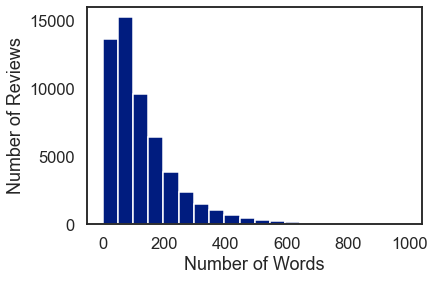

In [313]:
import seaborn as sns
sns.set_style('white')
sns.set_palette('dark')
sns.set_context('talk')
ax = plt.hist(length, bins = 20)
plt.xlabel("Number of Words")
plt.ylabel("Number of Reviews");
#ax.set_xlabel('Number of Words')

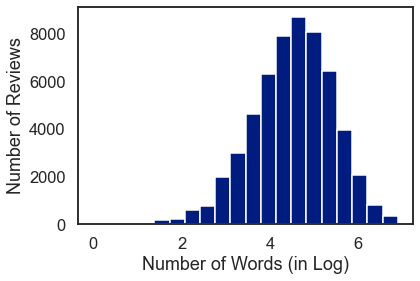

In [318]:
log_length = np.log1p(length);
plt.hist(log_length, bins = 20);
plt.xlabel("Number of Words (in Log)")
plt.ylabel("Number of Reviews");

In [319]:
describe(log_length)

DescribeResult(nobs=56000, minmax=(0.0, 6.899723107284872), mean=4.518839544162696, variance=0.8308347652554383, skewness=-0.391605571192689, kurtosis=0.3096271201054779)

**Taking the first 300 words for our models.**

In [456]:
x_train_pad = np.array(x_train)[:,:300]

In [457]:
x_test = encoder(list_ds_test_x)

In [458]:
x_test_pad = np.array(x_test)[:,:300]

In [459]:
vocabulary = encoder.get_vocabulary()
vocabulary = np.array(vocabulary)

In [460]:
vocabulary

array(['', '[UNK]', 'the', ..., 'thicker', 'suits', 'struck'],
      dtype='<U15')

In [461]:
x_train = x_train.numpy()

In [462]:
x_test = x_test.numpy()

## RNN Model

In [327]:
## Let's build a RNN

rnn_hidden_dim = 5
word_embedding_dim = 64
model_rnn = Sequential()
model_rnn.add(Embedding(max_features, word_embedding_dim))  #This layer takes each integer in the sequence and embeds it in a 64-dimensional vector
model_rnn.add(SimpleRNN(rnn_hidden_dim,
                    kernel_initializer=initializers.RandomNormal(stddev=0.001),
                    recurrent_initializer=initializers.Identity(gain=1.0),
                    activation='relu',
                    input_shape=x_train.shape[1:]))

model_rnn.add(Dense(1, activation='sigmoid'))

In [328]:
## Note that most of the parameters come from the embedding layer
model_rnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 64)          640000    
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 5)                 350       
                                                                 
 dense_5 (Dense)             (None, 1)                 6         
                                                                 
Total params: 640,356
Trainable params: 640,356
Non-trainable params: 0
_________________________________________________________________


In [329]:
rmsprop = keras.optimizers.RMSprop(lr = .0001)

model_rnn.compile(loss='binary_crossentropy',
              optimizer=rmsprop,
              metrics=['accuracy'])

C:\Users\anush\anaconda3\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [333]:
x_train_pad = np.asarray(x_train_pad).astype('float32')

In [334]:
x_test_pad = np.asarray(x_test_pad).astype('float32')

In [337]:
y_train = np.asarray(y_train).astype('float32')

In [338]:
y_test = np.asarray(y_test).astype('float32')

In [339]:
batch_size = 100
model_rnn.fit(x_train_pad, y_train,
          batch_size=batch_size,
          epochs=7,
          validation_data=(x_test_pad, y_test))

Epoch 1/7
560/560 [==============================] - 29s 51ms/step - loss: 0.4788 - accuracy: 0.7503 - val_loss: 0.2909 - val_accuracy: 0.8789
Epoch 2/7
560/560 [==============================] - 32s 56ms/step - loss: 0.2802 - accuracy: 0.8841 - val_loss: 0.2649 - val_accuracy: 0.8919
Epoch 3/7
560/560 [==============================] - 34s 60ms/step - loss: 0.2341 - accuracy: 0.9058 - val_loss: 0.2301 - val_accuracy: 0.9102
Epoch 4/7
560/560 [==============================] - 34s 60ms/step - loss: 0.2109 - accuracy: 0.9179 - val_loss: 0.2782 - val_accuracy: 0.8878
Epoch 5/7
560/560 [==============================] - 35s 62ms/step - loss: 0.1969 - accuracy: 0.9226 - val_loss: 0.2183 - val_accuracy: 0.9131
Epoch 6/7
560/560 [==============================] - 33s 58ms/step - loss: 0.1864 - accuracy: 0.9278 - val_loss: 0.2410 - val_accuracy: 0.9040
Epoch 7/7
560/560 [==============================] - 34s 60ms/step - loss: 0.1801 - accuracy: 0.9310 - val_loss: 0.2084 - val_accuracy: 0.9178

In [340]:
score, acc = model_rnn.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

380/380 [==============================] - 14s 37ms/step - loss: 50.4615 - accuracy: 0.8407
Test score: 50.4615478515625
Test accuracy: 0.8406842350959778


## RNN 2

In [344]:
## Let's build a RNN

rnn_hidden_dim = 10
word_embedding_dim = 128
model_rnn = Sequential()
model_rnn.add(Embedding(max_features, word_embedding_dim))  #This layer takes each integer in the sequence and embeds it in a 128-dimensional vector
model_rnn.add(SimpleRNN(rnn_hidden_dim,
                    kernel_initializer=initializers.RandomNormal(stddev=0.001),
                    recurrent_initializer=initializers.Identity(gain=1.0),
                    activation='relu',
                    input_shape=x_train.shape[1:]))

model_rnn.add(Dense(1, activation='sigmoid'))

In [345]:
## Note that most of the parameters come from the embedding layer
model_rnn.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 128)         1280000   
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 10)                1390      
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,281,401
Trainable params: 1,281,401
Non-trainable params: 0
_________________________________________________________________


In [346]:
rmsprop = keras.optimizers.RMSprop(lr = .0001)

model_rnn.compile(loss='binary_crossentropy',
              optimizer=rmsprop,
              metrics=['accuracy'])

In [333]:
x_train_pad = np.asarray(x_train_pad).astype('float32')

In [334]:
x_test_pad = np.asarray(x_test_pad).astype('float32')

In [337]:
y_train = np.asarray(y_train).astype('float32')

In [338]:
y_test = np.asarray(y_test).astype('float32')

In [347]:
batch_size = 100
model_rnn.fit(x_train_pad, y_train,
          batch_size=batch_size,
          epochs=7,
          validation_data=(x_test_pad, y_test))

Epoch 1/7
560/560 [==============================] - 42s 75ms/step - loss: 0.4570 - accuracy: 0.7755 - val_loss: 0.2623 - val_accuracy: 0.8938
Epoch 2/7
560/560 [==============================] - 41s 73ms/step - loss: 0.2604 - accuracy: 0.8947 - val_loss: 0.2598 - val_accuracy: 0.8947
Epoch 3/7
560/560 [==============================] - 42s 75ms/step - loss: 0.2196 - accuracy: 0.9129 - val_loss: 0.2239 - val_accuracy: 0.9162
Epoch 4/7
560/560 [==============================] - 48s 86ms/step - loss: 0.1999 - accuracy: 0.9233 - val_loss: 0.2101 - val_accuracy: 0.9188
Epoch 5/7
560/560 [==============================] - 43s 77ms/step - loss: 0.1860 - accuracy: 0.9289 - val_loss: 0.2026 - val_accuracy: 0.9201
Epoch 6/7
560/560 [==============================] - 43s 77ms/step - loss: 0.1763 - accuracy: 0.9322 - val_loss: 0.2204 - val_accuracy: 0.9155
Epoch 7/7
560/560 [==============================] - 43s 77ms/step - loss: 0.1696 - accuracy: 0.9347 - val_loss: 0.2170 - val_accuracy: 0.9179

## GRU

In [350]:
## Let's build a RNN

rnn_hidden_dim = 5
word_embedding_dim = 64
model_rnn = Sequential()
model_rnn.add(Embedding(max_features, word_embedding_dim))  #This layer takes each integer in the sequence and embeds it in a 64-dimensional vector
model_rnn.add(GRU(rnn_hidden_dim,
                    kernel_initializer=initializers.RandomNormal(stddev=0.001),
                    recurrent_initializer=initializers.Identity(gain=1.0),
                    activation='relu',
                    input_shape=x_train.shape[1:]))

model_rnn.add(Dense(1, activation='sigmoid'))

In [351]:
## Note that most of the parameters come from the embedding layer
model_rnn.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 64)          640000    
                                                                 
 gru_3 (GRU)                 (None, 5)                 1065      
                                                                 
 dense_9 (Dense)             (None, 1)                 6         
                                                                 
Total params: 641,071
Trainable params: 641,071
Non-trainable params: 0
_________________________________________________________________


In [352]:
rmsprop = keras.optimizers.RMSprop(lr = .0001)

model_rnn.compile(loss='binary_crossentropy',
              optimizer=rmsprop,
              metrics=['accuracy'])

In [353]:
batch_size = 100
model_rnn.fit(x_train_pad, y_train,
          batch_size=batch_size,
          epochs=7,
          validation_data=(x_test_pad, y_test))

Epoch 1/7
560/560 [==============================] - 37s 64ms/step - loss: 0.6927 - accuracy: 0.5264 - val_loss: 0.6922 - val_accuracy: 0.5280
Epoch 2/7
560/560 [==============================] - 39s 70ms/step - loss: 0.6917 - accuracy: 0.5291 - val_loss: 0.6910 - val_accuracy: 0.5280
Epoch 3/7
560/560 [==============================] - 41s 73ms/step - loss: 0.6901 - accuracy: 0.5292 - val_loss: 0.6893 - val_accuracy: 0.5284
Epoch 4/7
560/560 [==============================] - 42s 75ms/step - loss: 0.6885 - accuracy: 0.5293 - val_loss: 0.6881 - val_accuracy: 0.5286
Epoch 5/7
560/560 [==============================] - 43s 77ms/step - loss: 0.6876 - accuracy: 0.5294 - val_loss: 0.6874 - val_accuracy: 0.5288
Epoch 6/7
560/560 [==============================] - 45s 80ms/step - loss: 0.6870 - accuracy: 0.5294 - val_loss: 0.6871 - val_accuracy: 0.5289
Epoch 7/7
560/560 [==============================] - 46s 82ms/step - loss: 0.6865 - accuracy: 0.5294 - val_loss: 0.6868 - val_accuracy: 0.5290

## GRU2

In [354]:
## Let's build a RNN

rnn_hidden_dim = 10
word_embedding_dim = 128
model_rnn = Sequential()
model_rnn.add(Embedding(max_features, word_embedding_dim))  #This layer takes each integer in the sequence and embeds it in a 128-dimensional vector
model_rnn.add(GRU(rnn_hidden_dim,
                    kernel_initializer=initializers.RandomNormal(stddev=0.001),
                    recurrent_initializer=initializers.Identity(gain=1.0),
                    activation='relu',
                    input_shape=x_train.shape[1:]))

model_rnn.add(Dense(1, activation='sigmoid'))

In [355]:
## Note that most of the parameters come from the embedding layer
model_rnn.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 128)         1280000   
                                                                 
 gru_4 (GRU)                 (None, 10)                4200      
                                                                 
 dense_10 (Dense)            (None, 1)                 11        
                                                                 
Total params: 1,284,211
Trainable params: 1,284,211
Non-trainable params: 0
_________________________________________________________________


In [356]:
rmsprop = keras.optimizers.RMSprop(lr = .0001)

model_rnn.compile(loss='binary_crossentropy',
              optimizer=rmsprop,
              metrics=['accuracy'])

In [357]:
batch_size = 100
model_rnn.fit(x_train_pad, y_train,
          batch_size=batch_size,
          epochs=7,
          validation_data=(x_test_pad, y_test))

Epoch 1/7
560/560 [==============================] - 53s 94ms/step - loss: 0.6926 - accuracy: 0.5144 - val_loss: 0.6919 - val_accuracy: 0.5294
Epoch 2/7
560/560 [==============================] - 56s 100ms/step - loss: 0.6908 - accuracy: 0.5298 - val_loss: 0.6896 - val_accuracy: 0.5292
Epoch 3/7
560/560 [==============================] - 61s 110ms/step - loss: 0.6886 - accuracy: 0.5301 - val_loss: 0.6879 - val_accuracy: 0.5293
Epoch 4/7
560/560 [==============================] - 65s 116ms/step - loss: 0.6875 - accuracy: 0.5303 - val_loss: 0.6873 - val_accuracy: 0.5294
Epoch 5/7
560/560 [==============================] - 58s 104ms/step - loss: 0.6867 - accuracy: 0.5301 - val_loss: 0.6868 - val_accuracy: 0.5294
Epoch 6/7
560/560 [==============================] - 60s 106ms/step - loss: 0.6860 - accuracy: 0.5303 - val_loss: 0.6863 - val_accuracy: 0.5295
Epoch 7/7
560/560 [==============================] - 60s 107ms/step - loss: 0.6852 - accuracy: 0.5302 - val_loss: 0.6859 - val_accuracy: 

## LSTM

In [360]:
## Let's build a RNN


rnn_hidden_dim = 5
word_embedding_dim = 64
model_rnn = Sequential()
model_rnn.add(Embedding(max_features, word_embedding_dim))  #This layer takes each integer in the sequence and embeds it in a 64-dimensional vector
model_rnn.add(LSTM(rnn_hidden_dim,
                    kernel_initializer=initializers.RandomNormal(stddev=0.001),
                    recurrent_initializer=initializers.Identity(gain=1.0),
                    activation='relu',
                    input_shape=x_train.shape[1:]))

model_rnn.add(Dense(1, activation='sigmoid'))

In [361]:
## Note that most of the parameters come from the embedding layer
model_rnn.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, None, 64)          640000    
                                                                 
 lstm (LSTM)                 (None, 5)                 1400      
                                                                 
 dense_11 (Dense)            (None, 1)                 6         
                                                                 
Total params: 641,406
Trainable params: 641,406
Non-trainable params: 0
_________________________________________________________________


In [362]:
rmsprop = keras.optimizers.RMSprop(lr = .0001)

model_rnn.compile(loss='binary_crossentropy',
              optimizer=rmsprop,
              metrics=['accuracy'])

In [365]:
batch_size = 100
model_rnn.fit(x_train_pad, y_train,
          batch_size=batch_size,
          epochs=7,
          validation_data=(x_test_pad, y_test))

Epoch 1/7
560/560 [==============================] - 42s 74ms/step - loss: 317936192.0000 - accuracy: 0.5313 - val_loss: 46329012224.0000 - val_accuracy: 0.5328
Epoch 2/7
560/560 [==============================] - 42s 75ms/step - loss: 15802331136.0000 - accuracy: 0.5329 - val_loss: 16284268.0000 - val_accuracy: 0.5331
Epoch 3/7
560/560 [==============================] - 43s 76ms/step - loss: 154843296.0000 - accuracy: 0.5342 - val_loss: 3079774.7500 - val_accuracy: 0.5331
Epoch 4/7
560/560 [==============================] - 42s 75ms/step - loss: 16837.3145 - accuracy: 0.5354 - val_loss: 2845847.7500 - val_accuracy: 0.5348
Epoch 5/7
560/560 [==============================] - 45s 81ms/step - loss: 160534592.0000 - accuracy: 0.5393 - val_loss: 3365095424.0000 - val_accuracy: 0.5403
Epoch 6/7
560/560 [==============================] - 47s 83ms/step - loss: 191507152.0000 - accuracy: 0.5394 - val_loss: 987396416.0000 - val_accuracy: 0.5424
Epoch 7/7
560/560 [==============================]

## Best Simple RNN

**Now we try variations of the first model by changing max_features and padding length.**

In [394]:
max_features = 20000
encoder = tf.keras.layers.TextVectorization(max_tokens = max_features)

In [395]:
encoder.adapt(x_train)

In [396]:
x_train = encoder(list_ds_train_x)

In [397]:
x_train_pad = np.array(x_train)[:,:400]

In [398]:
x_test = encoder(list_ds_test_x)

In [399]:
x_test_pad = np.array(x_test)[:,:400]

In [400]:
x_train

<tf.Tensor: shape=(56000, 991), dtype=int64, numpy=
array([[ 376,   30,    5, ...,    0,    0,    0],
       [ 700, 3132,  136, ...,    0,    0,    0],
       [  15,  495, 4948, ...,    0,    0,    0],
       ...,
       [ 334,   54, 9058, ...,    0,    0,    0],
       [  15,   99,    5, ...,    0,    0,    0],
       [  14,  341,   89, ...,    0,    0,    0]], dtype=int64)>

## RNN Model

In [401]:
## Let's build a RNN

rnn_hidden_dim = 5
word_embedding_dim = 64
model_rnn = Sequential()
model_rnn.add(Embedding(max_features, word_embedding_dim))  #This layer takes each integer in the sequence and embeds it in a 64-dimensional vector
model_rnn.add(SimpleRNN(rnn_hidden_dim,
                    kernel_initializer=initializers.RandomNormal(stddev=0.001),
                    recurrent_initializer=initializers.Identity(gain=1.0),
                    activation='relu',
                    input_shape=x_train.shape[1:]))

model_rnn.add(Dense(1, activation='sigmoid'))

In [402]:
## Note that most of the parameters come from the embedding layer
model_rnn.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, None, 64)          1280000   
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 5)                 350       
                                                                 
 dense_12 (Dense)            (None, 1)                 6         
                                                                 
Total params: 1,280,356
Trainable params: 1,280,356
Non-trainable params: 0
_________________________________________________________________


In [403]:
rmsprop = keras.optimizers.RMSprop(lr = .0001)

model_rnn.compile(loss='binary_crossentropy',
              optimizer=rmsprop,
              metrics=['accuracy'])

In [404]:
x_train_pad = np.asarray(x_train_pad).astype('float32')

In [405]:
x_test_pad = np.asarray(x_test_pad).astype('float32')

In [406]:
y_train = np.asarray(y_train).astype('float32')

In [407]:
y_test = np.asarray(y_test).astype('float32')

In [408]:
batch_size = 100
model_rnn.fit(x_train_pad, y_train,
          batch_size=batch_size,
          epochs=7,
          validation_data=(x_test_pad, y_test))

Epoch 1/7
560/560 [==============================] - 44s 78ms/step - loss: 0.5326 - accuracy: 0.7225 - val_loss: 0.3668 - val_accuracy: 0.8411
Epoch 2/7
560/560 [==============================] - 47s 84ms/step - loss: 0.3078 - accuracy: 0.8720 - val_loss: 0.2385 - val_accuracy: 0.9030
Epoch 3/7
560/560 [==============================] - 50s 89ms/step - loss: 0.2339 - accuracy: 0.9048 - val_loss: 0.2312 - val_accuracy: 0.9018
Epoch 4/7
560/560 [==============================] - 55s 99ms/step - loss: 0.2063 - accuracy: 0.9172 - val_loss: 0.2174 - val_accuracy: 0.9116
Epoch 5/7
560/560 [==============================] - 51s 92ms/step - loss: 0.1903 - accuracy: 0.9244 - val_loss: 0.2285 - val_accuracy: 0.9093
Epoch 6/7
560/560 [==============================] - 48s 85ms/step - loss: 0.1792 - accuracy: 0.9303 - val_loss: 0.2104 - val_accuracy: 0.9186
Epoch 7/7
560/560 [==============================] - 48s 86ms/step - loss: 0.1701 - accuracy: 0.9342 - val_loss: 0.2501 - val_accuracy: 0.9078

## Best Simple RNN

**Once again we try variations of the first model by changing max_features and padding length.**

In [409]:
max_features = 5000
encoder = tf.keras.layers.TextVectorization(max_tokens = max_features)

In [426]:
encoder.adapt(x_train)

In [427]:
x_train = encoder(list_ds_train_x)

In [429]:
x_train_pad = np.array(x_train)[:,:200]

In [430]:
x_test = encoder(list_ds_test_x)

In [431]:
x_test_pad = np.array(x_test)[:,:200]

In [432]:
x_train

<tf.Tensor: shape=(56000, 991), dtype=int64, numpy=
array([[ 376,   30,    5, ...,    0,    0,    0],
       [ 700, 3132,  136, ...,    0,    0,    0],
       [  15,  495, 4948, ...,    0,    0,    0],
       ...,
       [ 334,   54,    1, ...,    0,    0,    0],
       [  15,   99,    5, ...,    0,    0,    0],
       [  14,  341,   89, ...,    0,    0,    0]], dtype=int64)>

## RNN Model

In [433]:
## Let's build a RNN

rnn_hidden_dim = 5
word_embedding_dim = 64
model_rnn = Sequential()
model_rnn.add(Embedding(max_features, word_embedding_dim))  
model_rnn.add(SimpleRNN(rnn_hidden_dim,
                    kernel_initializer=initializers.RandomNormal(stddev=0.001),
                    recurrent_initializer=initializers.Identity(gain=1.0),
                    activation='relu',
                    input_shape=x_train.shape[1:]))

model_rnn.add(Dense(1, activation='sigmoid'))

In [434]:
## Note that most of the parameters come from the embedding layer
model_rnn.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, None, 64)          320000    
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 5)                 350       
                                                                 
 dense_13 (Dense)            (None, 1)                 6         
                                                                 
Total params: 320,356
Trainable params: 320,356
Non-trainable params: 0
_________________________________________________________________


In [435]:
rmsprop = keras.optimizers.RMSprop(lr = .0001)

model_rnn.compile(loss='binary_crossentropy',
              optimizer=rmsprop,
              metrics=['accuracy'])

In [436]:
x_train_pad = np.asarray(x_train_pad).astype('float32')

In [437]:
x_test_pad = np.asarray(x_test_pad).astype('float32')

In [438]:
y_train = np.asarray(y_train).astype('float32')

In [439]:
y_test = np.asarray(y_test).astype('float32')

In [440]:
batch_size = 100
model_rnn.fit(x_train_pad, y_train,
          batch_size=batch_size,
          epochs=7,
          validation_data=(x_test_pad, y_test))

Epoch 1/7
560/560 [==============================] - 22s 39ms/step - loss: 0.4746 - accuracy: 0.7607 - val_loss: 0.3187 - val_accuracy: 0.8631
Epoch 2/7
560/560 [==============================] - 21s 38ms/step - loss: 0.3035 - accuracy: 0.8699 - val_loss: 0.2643 - val_accuracy: 0.8873
Epoch 3/7
560/560 [==============================] - 22s 40ms/step - loss: 0.2570 - accuracy: 0.8945 - val_loss: 0.2746 - val_accuracy: 0.8854
Epoch 4/7
560/560 [==============================] - 26s 46ms/step - loss: 0.2369 - accuracy: 0.9050 - val_loss: 0.2435 - val_accuracy: 0.8994
Epoch 5/7
560/560 [==============================] - 24s 43ms/step - loss: 0.2251 - accuracy: 0.9101 - val_loss: 0.2357 - val_accuracy: 0.9042
Epoch 6/7
560/560 [==============================] - 25s 45ms/step - loss: 0.2169 - accuracy: 0.9139 - val_loss: 0.2288 - val_accuracy: 0.9091
Epoch 7/7
560/560 [==============================] - 24s 42ms/step - loss: 0.2099 - accuracy: 0.9179 - val_loss: 0.2269 - val_accuracy: 0.9074